In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from helpers.utilities import *

In [2]:
from os import chdir
chdir('..')

In [3]:
%%capture
%load_ext rpy2.ipython
%R library(ggplot2)
%R library(factoextra);

While analyzing the PCA plots for protein levels two problems have arisen:
- the loadings plot did not show any variables that define PC2
  - in order to select variables that explain both PC1 and PC2, a way to extract the contributions of variables of each PC (but not of joint PC1 and PC2) was needed
- it was not obvious how are the contributions defined, given different terminologies in use

This notebook addresses these questions using the protein levels data.

### Loading the data

In [4]:
protein_levels = read_csv('data/clean/protein/levels.csv', index_col=2).drop(['soma_id', 'target_full_name', 'entrez_gene_symbol'], axis=1)

In [5]:
def z_score(v):
    return (v - v.mean()) / v.std()

In [6]:
from numpy import log10

In [7]:
log_matrix = protein_levels.applymap(log10)
z_log_matrix = log_matrix.apply(z_score).apply(z_score, axis=1)

In [8]:
%%R -i z_log_matrix -o pca
pca = prcomp(t(z_log_matrix), scale=T)

## Analysis

### A quick look at the distribution of contributions to PC1/2

In [9]:
%%R
pc_contributions_distribution = function(pca_result, axes, choice='var', labels=FALSE) {
    g = fviz_pca_contrib(pca, choice=choice, axes=axes)
    if(!labels)
        g = g + theme(
            axis.text.x=element_blank(),
            axis.ticks.x=element_blank()
        )
    g
}

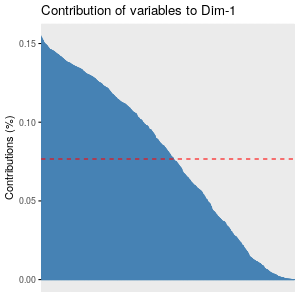

In [10]:
%%R -w 300 -h 300 -u px
# "Reference line corresponds to the expected value if the contribution where uniform"
pc_contributions_distribution(pca, axes=1)

The cut-off point for PC1 is much more to the right (PC1 has a heavy tail), thus more variables contribute to this dimension (compared to PC2, below). Dr Tim noted that similar pattern appears when the data are not centered, as then the first PC is essentially swapping the dataset into the origin.

While the z_log_matrix might not be centered on zero (due to the order of z-scores) the `prcomp` function does center it anyway (when scale=T).

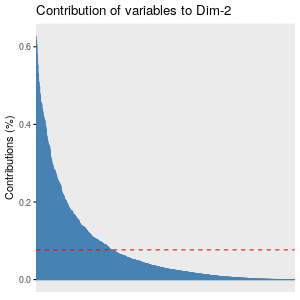

In [11]:
%%R -w 300 -h 300 -u px
pc_contributions_distribution(pca, axes=2)

While PC2 contributions are much more clearly defined by a small number of proteins, these dimensions do not account for enough variation to be shown on the original biplot.

### Getting the top contributors for each of the PCs

Loadings are named "rotations" in `prcomp`; columns correspond to the eigenvectors.

In [12]:
%%R -o loadings -o stdev
loadings = as.data.frame(pca$rotation)
stdev = as.data.frame(pca$sdev)

In [13]:
loadings.head()

,PC1,PC2,PC3,PC4,PC5,...,PC78,PC79,PC80,PC81,PC82
CHIP,-0.030286,-0.010796,0.019527,-0.018871,-0.001675,...,0.019079,0.002251,0.022151,-0.027124,-0.629210
CEBPB,-0.013677,-0.053114,-0.035227,0.040743,0.016014,...,-0.048504,0.010487,-0.029901,-0.013329,0.216258
NSE,0.033534,-0.011904,0.032665,0.024509,-0.001668,...,-0.038495,-0.003225,0.016193,-0.005210,0.362001
PIAS4,0.001750,-0.052516,-0.044091,0.049317,0.019133,...,0.009833,-0.070958,0.014760,-0.022986,0.267293
IL-10 Ra,0.032442,0.015214,0.002669,-0.007186,0.022590,...,0.008955,0.064745,0.062419,-0.017625,0.081871


In [14]:
from helpers.unsupervised import top_variables

In [15]:
show_source(top_variables)

In [16]:
def top_variables(loadings, pc, n=20):
    return loadings[pc].abs().nlargest(n)

Quick check to verify that my results are same as of the R-package:

In [17]:
top_variables(loadings, 'PC1', n=5) # I do not scale by variance - do not need it

hnRNP A/B    0.039330
IMB1         0.039219
STAT3        0.039196
PTK6         0.039172
FGF9         0.039125
Name: PC1, dtype: float64

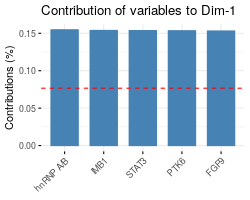

In [18]:
%%R -w 250 -h 200 -u px
fviz_pca_contrib(pca, choice="var", axes=1, top=5)

### How are the contributions are defined?

I recreate the calculation of contributions step-by-step for benefit of the reader (including me during the write-up):

1) The loadings are normalized (scaled to unit vector):

In [19]:
from numpy import isclose

assert all(
    isclose(pc_squared, 1) # equal 1 or very, very close
    # (rtol=1e-05, atol=1e-08) - to allow for rounding errors
    for pc_squared in loadings.pow(2).sum()
)

2) "sdev" gives us the square root of eigenvalues, which can be used to calculate the variance explained by each principal component:

In [20]:
variance_by_pc = stdev.pow(2)
variance_explained = variance_by_pc / variance_by_pc.sum()
variance_explained.columns = ['variance_explained']
variance_explained.index = 'PC' + variance_explained.index
variance_explained.head()

,variance_explained
PC1,0.479502
PC2,0.106114
PC3,0.045693
PC4,0.034823
PC5,0.030572


In documentation the contributions are defined as:

$\text{contrib} = \frac{\text{variable.cos}^2 \cdot 100}{\text{total cos}^2 \text{of the component}}$

As the loadings are cosines of rotation of variables required to form the PCs:

In [21]:
absolute_contributions = loadings.pow(2) * variance_explained.variance_explained
relative_contributions = 100 * absolute_contributions / absolute_contributions.sum() 

In [22]:
relative_contributions['PC1'].nlargest()

hnRNP A/B    0.154683
IMB1         0.153810
STAT3        0.153632
PTK6         0.153442
FGF9         0.153075
Name: PC1, dtype: float64

Which agrees with the values on the plot above.

**But how are the contributions for more than one PC calculated?**

These are just means of contributions (i.e. means of squared loadings, weighted by variance explained by each of the principal components):

In [23]:
pc_1_2_contrib = absolute_contributions[['PC1', 'PC2']].mean(axis=1)
(100 * pc_1_2_contrib / pc_1_2_contrib.sum()).nlargest()

KREM2        0.127032
hnRNP A/B    0.126739
SPARCL1      0.126043
IMB1         0.126038
STAT3        0.125892
dtype: float64

Please, compare with this plot:

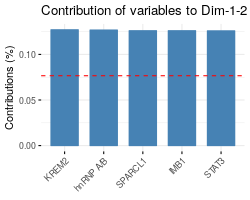

In [24]:
%%R -w 250 -h 200 -u px
fviz_pca_contrib(pca, choice="var", axes=1:2, top=5)

This is of course different from getting a mean of relative contributions (which would assume equal importance of each of the principal components):

In [25]:
relative_contributions[['PC1', 'PC2']].mean(axis=1).nlargest()

Plasmin    0.315266
ANP        0.311123
STAB2      0.303710
FGF-8B     0.302288
PECAM-1    0.293163
dtype: float64